# **Part A**
Count / Frequency based Naive Bayes Classifier

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        for c in self.classes:
            X_c = X_counts[y_array == c]
            n_samples = len(y_array)

            # COMPLETED TODO 1: Calculate the log prior P(C)
            # P(C) = (Number of samples in class c) / (Total number of samples)
            self.class_priors[c] = np.log(X_c.shape[0] / n_samples)

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Apply Laplace smoothing (additive smoothing, alpha=1.0 default):
            # P(w_i | C) = (count(w_i, C) + alpha) / (total_words_in_C + alpha * vocab_size)

            # COMPLETED TODO 2: Calculate the numerator (with Laplace smoothing)
            numerator = feature_sum + self.alpha

            # COMPLETED TODO 3: Calculate the denominator (with Laplace smoothing)
            denominator = total_mass + self.alpha * self.vocabulary_size

            # COMPLETED TODO 4: Calculate the log likelihood
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []

        for i in range(X_counts.shape[0]):
            scores = {}

            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # COMPLETED TODO 5: Complete the log probability calculation for the likelihood term
                # Add log likelihoods contribution (Log-Sum Trick):
                # log_prob += sum(count(w_i) * log(P(w_i|C)))
                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])

                scores[c] = log_prob

            # COMPLETED TODO 6: Find the key (class label) with the maximum score
            predicted_class = max(scores, key=scores.get)

            y_pred.append(predicted_class)

        # COMPLETED TODO 7: Return the final predictions array
        return np.array(y_pred)


In [2]:
# Load and Prepare Data
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    print(f"Train samples: {len(train_df)}")
    print(f"Dev samples: {len(dev_df)}")
    print(f"Test samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev, y_dev = dev_df['sentence'], dev_df['label']
    X_test, y_test = test_df['sentence'], test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_dev, y_dev = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []


Train samples: 180040
Dev samples: 30212
Test samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [3]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    # COMPLETED TODO: Set appropriate ngram_range and min_df
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        ngram_range=(1, 2),  # Unigrams and bigrams
        min_df=2  # Ignore terms that appear in fewer than 2 documents
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # COMPLETED TODO: Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)
    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # COMPLETED TODO: Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)


    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")

    # COMPLETED TODO: Initialize the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # COMPLETED TODO: Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")

else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")


Fitting Count Vectorizer and transforming training data...
Vocabulary size: 301234
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [4]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

# COMPLETED TODO: Predict y_test_pred using X_test_counts
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")



=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7571
              precision    recall  f1-score   support

  BACKGROUND       0.57      0.56      0.57      3621
 CONCLUSIONS       0.63      0.69      0.66      4571
     METHODS       0.81      0.89      0.85      9897
   OBJECTIVE       0.60      0.43      0.50      2333
     RESULTS       0.87      0.80      0.84      9713

    accuracy                           0.76     30135
   macro avg       0.70      0.68      0.68     30135
weighted avg       0.76      0.76      0.75     30135

Macro-averaged F1 score: 0.6825


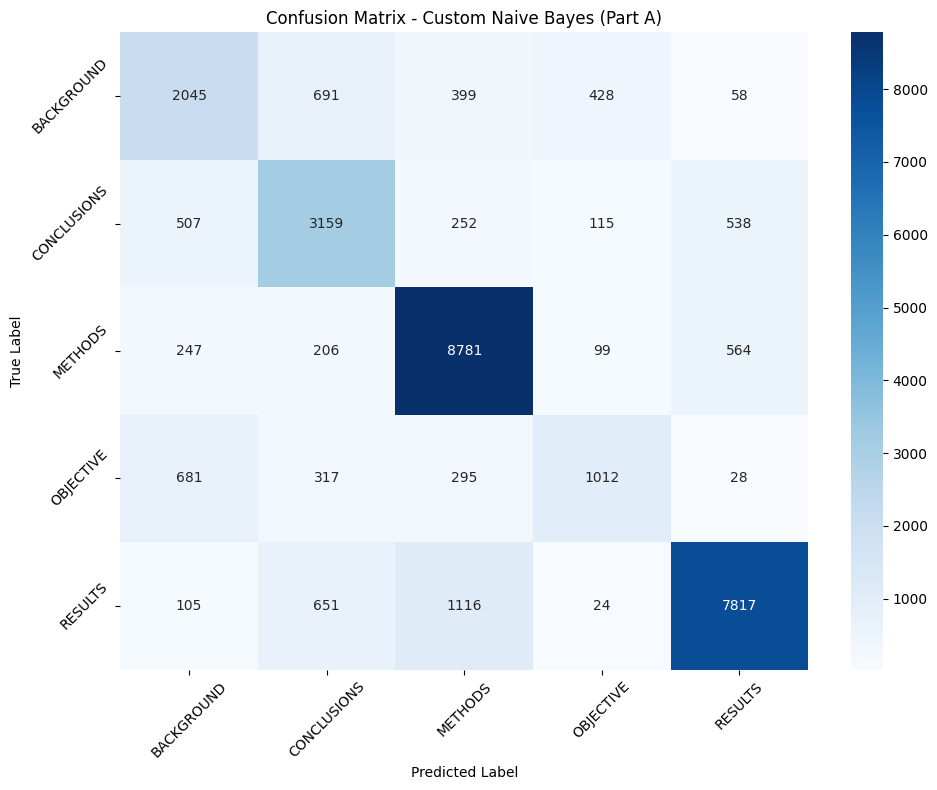

In [5]:
# Confusion Matrix on test set
# COMPLETED TODO: Generate a visual confusion matrix (heatmap)
if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix - Custom Naive Bayes (Part A)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()


# **Part B**
TF-IDF score based Classifier with Hyperparameter Tuning

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# COMPLETED TODO: Define a Pipeline named 'pipeline' using TfidfVectorizer and MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english'
    )),
    ('nb', MultinomialNB())
])

# COMPLETED TODO: Train the initial pipeline on the training set
print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")


# Predict and evaluate on test set
# COMPLETED TODO: Predict y_test_pred and calculate metrics
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred_b = pipeline.predict(X_test)
if y_test_pred_b is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred_b):.4f}")
    print(classification_report(y_test, y_test_pred_b, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred_b, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available.")


# Hyperparameter Tuning using GridSearchCV

# COMPLETED TODO: Define the parameter grid 'param_grid'
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],  # Unigrams, unigrams+bigrams, bigrams
    'nb__alpha': [0.1, 0.5, 1.0, 2.0]  # Smoothing parameter
}

# COMPLETED TODO: Initialize GridSearchCV using the pipeline and param_grid
# FIXED: Changed n_jobs=-1 to n_jobs=1 to avoid Python 3.13 multiprocessing warnings
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=1,  # Changed from -1 to 1 to avoid multiprocessing errors
    verbose=1
)

print("\nStarting Hyperparameter Tuning on Development Set...")
# COMPLETED TODO: Fit the GridSearchCV object using the development data
grid.fit(X_dev, y_dev)
print("Grid search complete.")


if grid is not None and hasattr(grid, 'best_params_'):
    # COMPLETED TODO: Print the best parameters and the corresponding best cross-validation score
    print(f"\nBest Parameters: {grid.best_params_}")
    print(f"Best CV Score (F1 Macro): {grid.best_score_:.4f}")
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")


Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.6996
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.37      0.46      3621
 CONCLUSIONS       0.61      0.55      0.57      4571
     METHODS       0.68      0.88      0.77      9897
   OBJECTIVE       0.72      0.09      0.16      2333
     RESULTS       0.77      0.85      0.81      9713

    accuracy                           0.70     30135
   macro avg       0.68      0.55      0.56     30135
weighted avg       0.69      0.70      0.67     30135

Macro-averaged F1 score: 0.5555

Starting Hyperparameter Tuning on Development Set...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Grid search complete.

Best Parameters: {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}
Best CV Score (F1 Macro): 0.5925


# **Part C**
Bayes Optimal Classifier (Ensemble Method with Soft Voting)

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Dynamic Data Sampling (DO NOT CHANGE)
BASE_SAMPLE_SIZE = 10000

# Prompt the user for their full SRN
FULL_SRN = input("Please enter your full SRN (e.g., PES2UG23CS345): ")

try:
    # Extract the last three characters and convert to integer
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        # Fallback if input is too short
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    # Fallback if SRN is not entered or format is incorrect
    print("WARNING: SRN input failed or format is incorrect. Using 0 offset.")
    srn_value = 0

# Calculate the final sample size: 10000 + last three SRN digits
SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"SRN: {FULL_SRN}")
print(f"SRN Suffix Value: {srn_value}")
print(f"Using dynamic sample size: {SAMPLE_SIZE}")


# Placeholder initialization in case data wasn't loaded in the environment
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")


# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),  # Using unigrams only to keep feature space small for diverse models
    'min_df': 5
}

# Define the five diverse hypotheses/pipelines (DO NOT CHANGE)

# H1: Multinomial Naive Bayes
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

# H2: Logistic Regression
h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])

# H3: Random Forest Classifier
# FIXED: Changed n_jobs=-1 to n_jobs=1
h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=1), cv=3, method='isotonic'
    ))
])

# H4: Decision Tree Classifier
h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'
    ))
])

# H5: K-Nearest Neighbors
# FIXED: Changed n_jobs=-1 to n_jobs=1
h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=1), cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']


# Training and BOC Implementation

# COMPLETED TODO: Train all five hypotheses on X_train_sampled and y_train_sampled
print("\nTraining all base models...")
for i, h in enumerate(hypotheses):
    print(f"Training {hypothesis_names[i]}...")
    h.fit(X_train_sampled, y_train_sampled)
    print(f"{hypothesis_names[i]} training complete.")

print("All base models trained.")


# COMPLETED TODO: Implement the Posterior Weight Calculation (P(h_i | D))
print("\nCalculating Posterior Weights...")

# Split the sampled training data into sub-train and validation
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.3, random_state=42, stratify=y_train_sampled
)

# Create label encoder for converting class labels to indices
le = LabelEncoder()
le.fit(y_train_sampled)  # Fit on full training data to get all classes

# Train all five hypotheses on sub-training set
h_subtrained = []
log_likelihoods = []

for i, h in enumerate(hypotheses):
    h_clone = Pipeline(h.steps)
    h_clone.fit(X_train_sub, y_train_sub)
    h_subtrained.append(h_clone)
    
    # Calculate log-likelihood on validation set
    y_val_pred_proba = h_clone.predict_proba(X_val_sub)
    
    # FIXED: Encode class labels to integer indices for array indexing
    y_val_indices = le.transform(y_val_sub)
    
    # Convert predicted probabilities to log-likelihood
    n_samples = len(y_val_sub)
    # Use encoded indices to safely index the probability matrix
    log_ll = np.sum(np.log(y_val_pred_proba[np.arange(n_samples), y_val_indices]))
    log_likelihoods.append(log_ll)
    print(f"{hypothesis_names[i]} - Validation Log-Likelihood: {log_ll:.4f}")

# Normalize log-likelihoods to get posterior weights
# Convert log-likelihoods to likelihoods and normalize
likelihoods = np.exp(np.array(log_likelihoods) - np.max(log_likelihoods))  # Numerical stability
posterior_weights = likelihoods / np.sum(likelihoods)

print(f"\nCalculated Posterior Weights: {posterior_weights}")
for i, w in enumerate(posterior_weights):
    print(f"  {hypothesis_names[i]}: {w:.4f}")


SRN: PES2UG23CS345
SRN Suffix Value: 345
Using dynamic sample size: 10345
Actual sampled training set size used: 10345

Training all base models...
Training NaiveBayes...
NaiveBayes training complete.
Training LogisticRegression...


/home/worm/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/worm/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


LogisticRegression training complete.
Training RandomForest...
RandomForest training complete.
Training DecisionTree...
DecisionTree training complete.
Training KNN...
KNN training complete.
All base models trained.

Calculating Posterior Weights...
NaiveBayes - Validation Log-Likelihood: -3013.3103


/home/worm/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/worm/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


LogisticRegression - Validation Log-Likelihood: -2821.7364


/tmp/ipykernel_20893/1675951073.py:155: RuntimeWarning: divide by zero encountered in log
  log_ll = np.sum(np.log(y_val_pred_proba[np.arange(n_samples), y_val_indices]))


RandomForest - Validation Log-Likelihood: -inf
DecisionTree - Validation Log-Likelihood: -3916.3219
KNN - Validation Log-Likelihood: -4499.1819

Calculated Posterior Weights: [6.3170397e-84 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
  NaiveBayes: 0.0000
  LogisticRegression: 1.0000
  RandomForest: 0.0000
  DecisionTree: 0.0000
  KNN: 0.0000



Fitting the VotingClassifier (BOC approximation)...


/home/worm/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/worm/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.7090
Macro-averaged F1 Score: 0.6147

Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.55      0.37      0.44      3621
 CONCLUSIONS       0.61      0.56      0.58      4571
     METHODS       0.71      0.89      0.79      9897
   OBJECTIVE       0.66      0.35      0.45      2333
     RESULTS       0.80      0.81      0.80      9713

    accuracy                           0.71     30135
   macro avg       0.66      0.60      0.61     30135
weighted avg       0.70      0.71      0.69     30135



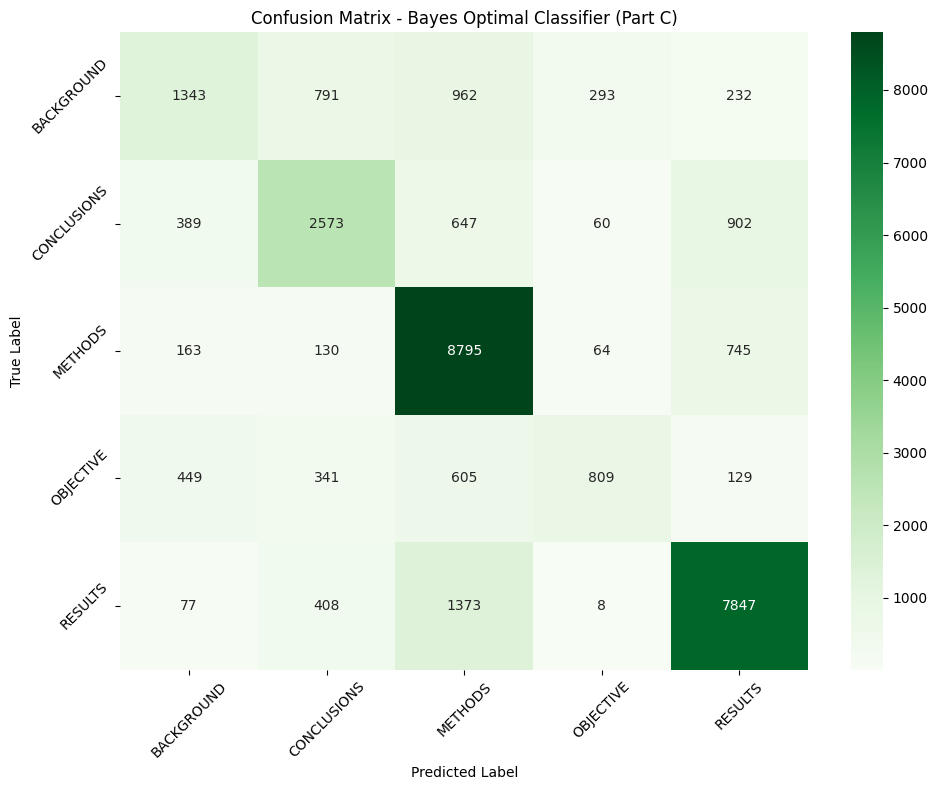

In [8]:
# Implement and Evaluate the Bayes Optimal Classifier
estimators = list(zip(hypothesis_names, hypotheses))

# BOC is approximated using soft voting with posterior weights
# FIXED: Changed n_jobs=-1 to n_jobs=1
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=1  # Changed from -1 to 1 to avoid multiprocessing errors
)

print("\nFitting the VotingClassifier (BOC approximation)...")
# COMPLETED TODO: Fit the VotingClassifier using the full sampled training data
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")


# Make the final BOC prediction on the test set
print("\nPredicting on test set...")
# COMPLETED TODO: Predict y_pred and evaluate
y_pred = boc_soft_voter.predict(X_test)


# Final Evaluation
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")

if y_pred is not None:
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro-averaged F1 Score: {f1_macro:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # COMPLETED TODO: Generate and visualize the Confusion Matrix (heatmap)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix - Bayes Optimal Classifier (Part C)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Evaluation skipped: Predictions not generated.")
